# TP 3 : implementing the Lasso

The goal of this practical sesion is to code an compare different solution to the Lasso regresion

/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7  -m notebook

## 1. Define the problem

Generate the data to play with

In [1]:
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
import time

n = 200              # number of examples (you can try with n = 1000 and n = 5000 (it may take some time...))
p = 2*n              # dimensionality of the problem

k = 5                # number of active variables
# creating features and normalizing them (normalization is not necessary)
np.random.seed(0)
X = np.random.randn(n,p)
X = (X - np.mean(X,axis = 0))/np.std(X,axis = 0)

t = np.arange(0,p)/(p-1);   # bulding the variance matrix !
S = np.zeros((p,p))
nn = 0.00001
for i in range(p):
    S[i,:] = np.exp(-(t-t[i])**2/nn);

X = X@(S**.5)
#X = X/np.std(X,axis = 0)
X = X/np.linalg.norm(X,axis=0)
X = np.array(X, order='F')


# generating optimal weights
ind = np.random.choice(p, k, replace=False)
weights = np.random.randn(k)
weights += 0.1+np.sign(weights)  # to get large enough weight

wopt = np.zeros(p)
wopt[ind] = weights

In [2]:
cvx.installed_solvers()

['ECOS', 'ECOS_BB', 'GUROBI', 'OSQP', 'SCIPY', 'SCS']

In [3]:
# generating output by X@w + noise
rsnr = 2
z = X[:,ind]@weights
stdnoise = np.std(z)/rsnr
y = z + stdnoise*np.random.randn(n) 

#print(np.mean(X,axis=0))
#print(np.std(X,axis=0))
print(np.mean(y))
print(np.std(y))


-0.007828481395382841
0.29965145751047934


In [4]:
b_ls = np.linalg.solve(X.T@X,X.T@y)
e_ls = np.sum((X@b_ls-z)**2)
print("Test error for the LS regression: {:0.4f}".format(e_ls))

b_ls = np.linalg.lstsq(X,y,rcond=-1)[0]
e_ls = np.sum((X@b_ls-z)**2)
print("Test error for the LS regression: {:0.4f}".format(e_ls))

b_ls = X.T@np.linalg.solve(X@X.T,y)
e_ls = np.sum((X@b_ls-z)**2)
print("Test error for the LS regression: {:0.4f}".format(e_ls))

Test error for the LS regression: 2.7231
Test error for the LS regression: 2.7204
Test error for the LS regression: 7.3671


## 2. Solve the Lasso using CVX

$$
\begin{array}{cl}
\displaystyle \min_\beta & \frac{1}{2} \|X\beta-y\|^2 + \lambda  \|\beta\|_1 
\end{array}
$$

In [5]:
lamb = 0.001*n;

w_c = cvx.Variable(p)
cvx_lasso = cvx.Minimize(.5*cvx.sum_squares(X@w_c-y) + lamb*cvx.norm(w_c, 1))
problem = cvx.Problem(cvx_lasso)
start = time.time()
problem.solve()
#problem.solve(solver=cvx.SCS,eps=1e-8)
t_cvx = time.time() - start
print("Execution time for the Lasso regression with CVX: {:0.4f}".format(t_cvx))
coef_cvx = w_c.value

e_cvx = np.sum((X@coef_cvx-z)**2)
print("Test error for the Lasso regression with CVX: {:0.4f}".format(e_cvx))

Execution time for the Lasso regression with CVX: 0.0802
Test error for the Lasso regression with CVX: 0.3323


### Check the optimality conditions 
$g = X^\top (X\beta - y)$
$$
\begin{array}{c l}
g_j + \lambda sign(\beta_j) = 0 & \mbox{ if } \beta_j \neq 0\\
|g_j| < \lambda & \mbox{ if } \beta_j = 0
\end{array}
$$

In [6]:
epsi = 1e-3
tol = 1e-4 

indzero = np.where(np.abs(coef_cvx)<epsi)
indnonzero = np.where(np.abs(coef_cvx)>epsi)
grad = X.T@(y-X@coef_cvx) # TOFILL
#exactOnzeros = -1
#exactOnNonZeros = 0
if indzero[0].shape[0]> 0:
    exactOnzeros = np.abs(grad[indzero]) - lamb                                   # TOFILL
if indnonzero[0].shape[0] > 0:
    exactOnNonZeros =   np.abs(grad[indnonzero] + lamb*np.sign(coef_cvx[indnonzero]))# TOFILL
bool_onzeros = exactOnzeros <  -tol
bool_nonzeros = exactOnNonZeros < tol
print(f'optimal on zeros : {bool_onzeros}')
print(f'optimal on nonzeros : {bool_nonzeros}')


optimal on zeros : [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  

### implement the following version 2 of the lasso using CVX
$$
\left\{
\begin{array}{cl}
\displaystyle \min_b & \frac{1}{2} \|Xb-y\|^2 \\
s.t.   & \|b\|_1 \leq t
\end{array}
\right.
$$

In [7]:
t = np.sum(np.abs(coef_cvx))

w_c = cvx.Variable(p)
o = cvx.Minimize(.5*cvx.sum_squares(X@w_c-y))
c = [cvx.norm(w_c, 1) <= t]
problem = cvx.Problem(o, c)
start = time.time()
problem.solve(solver=cvx.SCS,eps=1e-5)
t_cvx_2 = time.time() - start
print("Execution time for the Lasso regression with CVX: {:0.4f}".format(t_cvx_2))
coef_cvx_2 = w_c.value

e_cvx = np.sum((X@coef_cvx_2-z)**2)
print("Test error for the Lasso regression with CVX: {:0.4f}".format(e_cvx))

Execution time for the Lasso regression with CVX: 0.1226
Test error for the Lasso regression with CVX: 0.3323


In [8]:
print(t)
print(coef_cvx)

7.279238794918511
[-3.89296667e-23  2.42314967e-22  4.61535792e-22  5.20864262e-22
  8.10316494e-22  3.37907764e-22  5.47083209e-22  7.48498171e-22
  7.67757479e-22  9.44402818e-22  1.65441606e-21  1.86842448e-21
  1.84902395e-21  1.31792379e-21  9.76625683e-22  8.99634217e-22
  1.12972990e-21  3.46319034e-22 -4.23481509e-02  9.09153065e-22
 -5.78819322e-23  7.61826682e-23  8.07298319e-02  2.74687423e-22
  3.89882997e-22 -1.88730376e-22 -5.71997932e-22 -3.90106088e-22
 -2.16510719e-22  1.89320728e-22  5.38304158e-22  1.27081114e-21
  1.01452314e-21  6.03827748e-22  2.65808036e-22 -1.54396863e-22
 -4.14252057e-22 -8.17314849e-22 -8.92099789e-22 -1.03495649e-21
 -1.18025255e-21 -1.05481775e-22 -2.73369252e-03 -2.62383295e-02
 -6.30173037e-22 -4.35225171e-22 -3.97321116e-22 -1.82484973e-02
 -7.39985005e-22 -1.36377808e-21 -1.29924031e-21 -6.42585192e-22
 -8.92801944e-23 -1.13347827e-22 -2.41687085e-22 -6.96519621e-01
  1.97181106e-22  3.43531154e-22  9.99926769e-22  1.35627611e-21
  1.184

In [9]:
# check the KKT
mu = c[0].dual_value

# 1. Stationarity
epsi = 0.01
indnonzero = np.where(np.abs(coef_cvx)>epsi)[0]
print(X[:,indnonzero].T@(X[:,indnonzero]@coef_cvx_2[indnonzero] - y) + mu*np.sign(coef_cvx_2[indnonzero]))

# 2. Primal admisibility
print(np.sum(np.abs(coef_cvx_2)))
print(t)
print(np.sum(np.abs(coef_cvx_2)) <= t)

# 3. Dual Admissibility 
print(mu >= 0)

# 4. Complementarity 
print(mu*(np.sum(np.abs(coef_cvx_2)) - t))


[ 1.32973324e-03 -8.34437995e-04  3.06247590e-03  8.40230699e-04
  4.11707330e-04 -8.62535063e-04 -1.90087721e-04 -7.01942518e-04
 -4.69187867e-04  3.57127870e-03 -2.14052371e-04  1.90451897e-05
  7.50167869e-04  1.31996693e-03  6.67961826e-04  1.28243888e-03
 -6.41637702e-03 -3.78941474e-04 -1.72625854e-04]
7.279267584878751
7.279238794918511
False
True
5.757995228085458e-06


## Calculate and implement the dual version of the lasso
$$
\left\{
\begin{array}{cl}
\displaystyle \min_{b} & \frac{1}{2} \|X  b \|^2 \\
s.t.   & \|X^\top(Xb-y)\|_\infty \leq \lambda
\end{array}
\right.
$$

In [10]:
b3 = cvx.Variable(p)
o = cvx.Minimize(.5*cvx.sum_squares(X@b3))
c = [cvx.norm_inf(X.T@(X@b3-y)) <= lamb]
problem = cvx.Problem(o, c)

start = time.time()
problem.solve(solver=cvx.SCS,eps=1e-5)
t_cvx_2 = time.time() - start

print("Execution time for the Lasso regression with CVX: {:0.4f}".format(t_cvx_2))
coef_cvx_3 = b3.value
e_cvx = np.sum((X@coef_cvx_2-z)**2)
print("Test error for the Lasso regression with CVX: {:0.4f}".format(e_cvx))

Execution time for the Lasso regression with CVX: 1.9161
Test error for the Lasso regression with CVX: 0.3323


###  implement the lasso version 3 as the following standart QP
$$
\left\{
\begin{array}{cl}
\displaystyle \min_x & \frac{1}{2} x^\top H x + c^\top x \\
s.t.   & A x  \leq b \\
       &   0 \leq x 
\end{array}
\right.
$$

In [11]:
bloc = X.T @ X
H = np.concatenate((
    np.concatenate((bloc, -bloc), axis=0),
    np.concatenate((-bloc, bloc), axis=0)),
    axis=1)
I_H = np.eye(H.shape[0])
eps = 0.00000001
H = H+eps*I_H
c = np.concatenate((X.T @ y, -X.T @ y), axis=0)
A = np.ones((2 * p, 1));
b = t;
l = 10e-12;
verbose = 0;

x = cvx.Variable(2*p)
o = cvx.Minimize( .5*cvx.quad_form(x,H) - c@x)
c = [A.T@x <= b,
     x >=0 ]
problem = cvx.Problem(o, c)
#problem.solve(solver=cvx.SCS,eps=1e-5)
problem.solve()

coef_cvx_3 = x.value[0:p] - x.value[p:2*p] 
e_cvx = np.sum((X@coef_cvx_3-z)**2)
print("Test error for the Lasso regression with CVX: {:0.4f}".format(e_cvx))

Test error for the Lasso regression with CVX: 0.3323


## 3. Lasso: componentwise implementation

In [12]:
def lasso_cost(X,y,b,lamb):
    return (.5*np.sum((X@b-y)**2) + lamb*np.sum(np.abs(b)))

In [13]:
# test to check if the cost in decreasing
w = np.zeros(p)
r = y.copy()

print(lasso_cost(X,y,w,lamb))
j = 0
xk = X[:,j]
s = r + xk*w[j]
w_n = xk.T@s         
print(w_n)
w_n = np.sign(w_n)*np.maximum(np.abs(w_n)-lamb,0)
w[j] = w_n
print(w[j])
print(lasso_cost(X,y,w,lamb))


8.985228110911246
-0.278979755263524
-0.07897975526352397
8.9821092100405


70 0.000970098390140367
Execution time for the CW Lasso regression: 0.2862
Test error for the CW Lasso regression: 0.3324
2.7087943637214194


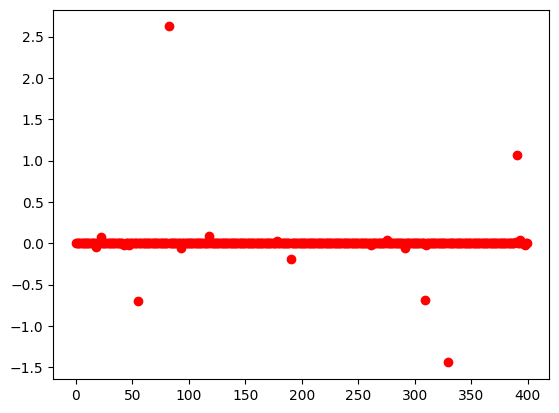

In [14]:
tol = 1e-3 

w = np.zeros(p)
nb_iter = 1000   
start = time.time()
r = y.copy()
for i in range(nb_iter):
    pp = np.random.permutation(p)
# Debug mode 
#    print(lasso_cost(X,y,w,lamb)) # debug mode
#    print("Test error for the Lasso CW: {:0.4f}".format(np.sum((X@w-z)**2)))

    for j in pp:
        xk = X[:,j]
        s = r + xk*w[j]
        w_n = xk.T@s             
        w_n = np.dot(xk,s)             
        w_n = np.sign(w_n)*np.maximum(np.abs(w_n)-lamb,0)
        # update of the residual
        r = r - xk*(w_n - w[j])
        w[j] = w_n
    # stopping condition—
    grad = -X.T@(y-X@w) 
    exactOnzeros = -1
    exactOnNonZeros = 0
    indzero = np.where(np.abs(w)<epsi)
    indnonzero = np.where(np.abs(w)>epsi)
    if indzero[0].shape[0]> 0:
        exactOnzeros = np.abs(grad[indzero]) - lamb
    if indnonzero[0].shape[0] > 0:
        exactOnNonZeros =   np.abs(grad[indnonzero] + lamb*np.sign(w[indnonzero]))
    M = np.max(np.maximum(np.max(np.abs(exactOnNonZeros)),np.maximum(exactOnzeros,0)))
#    print(i+1, M)
    if M < tol:
        break

print(i,M)
        
t_cw = time.time() - start
print("Execution time for the CW Lasso regression: {:0.4f}".format(t_cw))
e_cw = np.sum((X@w-z)**2)
print("Test error for the CW Lasso regression: {:0.4f}".format(e_cw))

print(lasso_cost(X,y,w,lamb))

plt.plot(w,'or')
plt.show()

## 4. Lasso: using SKlearn

In [15]:
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso, lasso_path

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso
reg_lasso = Lasso(alpha=lamb/n,max_iter=10000,fit_intercept=False)
start = time.time()
reg_lasso.fit(X, y)
t_skl = time.time() - start
print("Execution time for the Lasso regression with sklearn: {:0.4f}".format(t_skl))

coef_lasso = reg_lasso.coef_
e_skl = np.sum((X@coef_lasso-z)**2)
print("Test error for the Lasso regression: {:0.4f}".format(e_skl))
print("Lasso picked " + str(sum(coef_lasso != 0)) + " variables and eliminated the other " +  str(sum(coef_lasso == 0)) + " variables")

# https://scikit-learn.org/stable/modules/linear_model.html#lasso
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html
reg_lasso_CV = LassoCV(max_iter=10000,fit_intercept=False)
start = time.time()
reg_lasso_CV.fit(X, y)
t_sCV = time.time() - start
print("Execution time for the Lasso CV regression with sklearn: {:0.4f}".format(t_sCV))

coef_lasso_CV = reg_lasso_CV.coef_
e_sCV = np.sum((X@coef_lasso_CV-z)**2)
print("Test error for the Lasso CV regression: {:0.4f}".format(e_sCV))
print("Best alpha using built-in LassoCV: %f" % reg_lasso_CV.alpha_)
print("Lasso CV picked " + str(sum(coef_lasso_CV != 0)) + " variables and eliminated the other " +  str(sum(coef_lasso_CV == 0)) + " variables")


Execution time for the Lasso regression with sklearn: 0.0020
Test error for the Lasso regression: 0.3323
Lasso picked 24 variables and eliminated the other 376 variables
Execution time for the Lasso CV regression with sklearn: 3.1546
Test error for the Lasso CV regression: 0.3294
Best alpha using built-in LassoCV: 0.000884
Lasso CV picked 27 variables and eliminated the other 373 variables


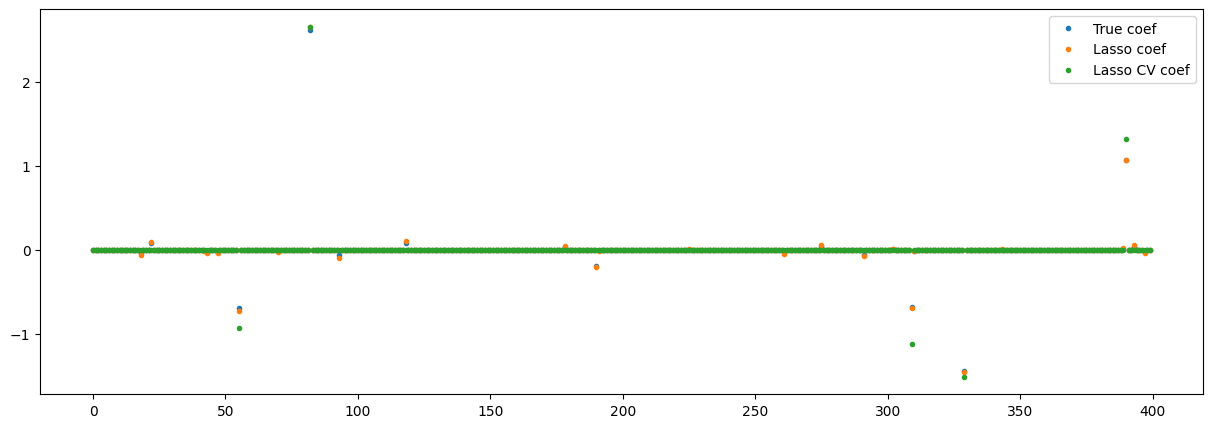

In [16]:
w = np.array([coef_lasso, coef_lasso_CV, wopt])

plt.figure(figsize=(15,5))
plt.plot(w.T,'.')
plt.legend(('True coef','Lasso coef', 'Lasso CV coef'))
plt.show()

## 5. path

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022887046720374282, tolerance: 0.0017970456221822492
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033750494458628794, tolerance: 0.0017970456221822492
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018604708854185747, tolerance: 0.0017970456221822492
  positive)


Execution time for the Lasso regression with sklearn: 1.0066
0.014404536253292183


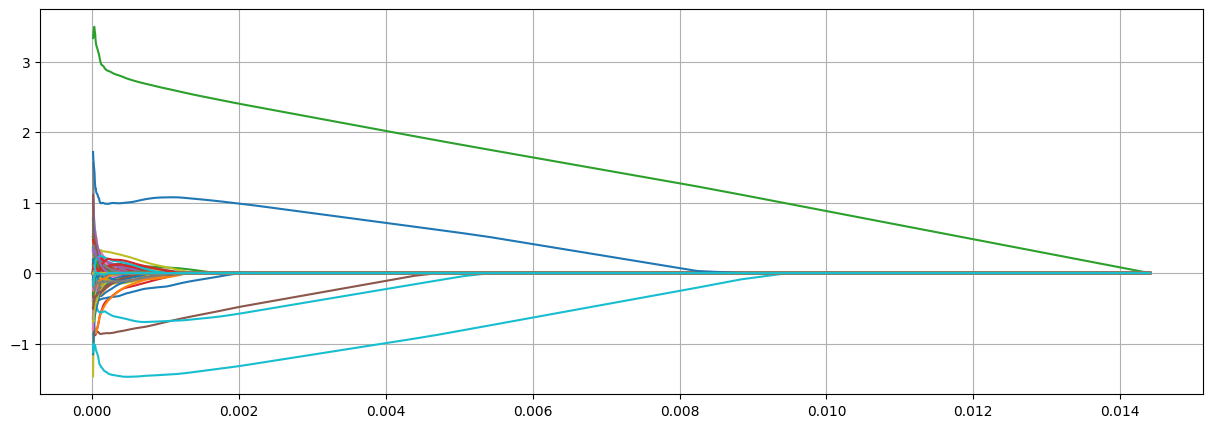

In [17]:
start = time.time()
alphas, coef_path, _ = lasso_path(X, y)
t_path = time.time() - start
print("Execution time for the Lasso regression with sklearn: {:0.4f}".format(t_path))

print(np.max(np.abs(X.T@y))/n)

plt.figure(figsize=(15,5))
plt.plot(alphas,coef_path.T)
plt.grid()
plt.show()

## 6. implement the lasso using the iteratively reweighted penalized least square approach


In [18]:
b_lasso = np.ones(p)

start = time.time()
for i in range(200):
    W = np.diag(1/np.abs(b_lasso))
    b_lasso = np.linalg.solve(X.T@X + lamb*W, X.T@y)

t_rwls = time.time() - start
print("Execution time for the Lasso regression with sklearn: {:0.4f}".format(t_rwls))

e_rwls = np.sum((X@b_lasso-z)**2)
print("Test error for the Lasso CV regression: {:0.4f}".format(e_rwls))


/Users/stephane/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in true_divide
  """
/Users/stephane/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


Execution time for the Lasso regression with sklearn: 1.7663
Test error for the Lasso CV regression: 0.3323


In [19]:
print((np.diag(W)))

[1.90356997e+258 2.38054963e+260 9.57631253e+099 6.33997161e+080
 6.28097214e+173 2.10854102e+142 5.37822517e+115             inf
 1.21486163e+157 1.83759478e+149 2.40012906e+094 2.66660423e+051
 3.59068326e+073 9.45000532e+210 1.30871694e+137 2.19435112e+056
 1.48270459e+018 1.03477308e+005 2.37195451e+001 1.40341227e+027
             inf 1.52231135e+027 1.23325560e+001 6.46462725e+027
 3.88549116e+122 3.46419649e+138 4.80227630e+097 6.48104121e+144
             inf 1.18920686e+230 8.84072212e+304 1.77171869e+202
 5.89522422e+156 3.55743793e+187             inf 5.87912509e+296
 3.99449897e+221 1.14087685e+083 2.26675101e+032 2.73607539e+017
 1.70359435e+012 1.22936994e+007 1.81584349e+002 4.18572192e+001
 1.66548769e+010 1.74623461e+029 1.42935132e+030 5.76312008e+001
 7.61970128e+002 8.80141805e+072 1.80156681e+204 1.40178534e+167
 3.68059268e+072 1.99807667e+027 6.98795365e+004 1.43595109e+000
 3.15535272e+042             inf 1.61223333e+118 1.68864625e+174
 2.74295780e+153 2.807166

In [25]:
import numpy as np

def soft_thresholding(x, l):
    """Soft thresholding operator."""
    return np.sign(x) * np.maximum(np.abs(x) - l, 0)

def lasso_regression_componentwise(X, y, l, max_iterations=100, tol=1e-4):
    """
    Compute Lasso regression coefficients using a componentwise approach.

    Parameters:
    X (numpy.ndarray): Design matrix of shape (n_samples, n_features).
    y (numpy.ndarray): Target vector of shape (n_samples,).
    l (float): Regularization parameter (L1 penalty).
    max_iterations (int): Maximum number of iterations for the componentwise Lasso algorithm.
    tol (float): Tolerance for convergence.

    Returns:
    numpy.ndarray: Lasso regression coefficients.
    """
    n_samples, n_features = X.shape
    beta = np.zeros(n_features)  # Initialize coefficients to zeros

    for i in range(max_iterations):
        beta_prev = np.copy(beta)

        for j in range(n_features):
            X_j = X[:, j]
            r = y - np.dot(X, beta) + beta[j] * X_j  # Residual excluding feature j
            beta[j] = soft_thresholding(np.dot(X_j, r), l) / np.dot(X_j, X_j)

        if np.linalg.norm(beta - beta_prev) < tol:
            break

    return beta

# Example usage
# X is your design matrix, y is your target vector, and l is the regularization parameter
start  = time.time()
coefficients = lasso_regression_componentwise(X, y, lamb)

t_chatGPT = time.time() - start
print("Execution time for the Lasso regression with sklearn: {:0.4f}".format(t_rwls))

e_chatGPT = np.sum((X@coefficients-z)**2)
print("Test error for the Lasso CV regression: {:0.4f}".format(e_rwls))


Execution time for the Lasso regression with sklearn: 1.7663
Test error for the Lasso CV regression: 0.3323


# 6. Summarize the results

In [26]:
import pandas as pd # we'll use pandas for data analysis

res = pd.DataFrame(index=["Classification error on the test set","Computation time"])
res.loc[:, 'CVX'] = (e_cvx,t_cvx)
res.loc[:, 'CW'] = (e_cw,t_cw)
res.loc[:, 'Sklearn'] = (e_skl,t_skl)
res.loc[:, 'Sklearn CV'] = (e_sCV,t_sCV)
res.loc[:, 'Reweighted LS'] = (e_rwls,t_rwls)
res.loc[:, 'ChatGPT'] = (e_chatGPT,t_chatGPT)

res

CVX        CW   Sklearn  \
Classification error on the test set  0.332278  0.332408  0.332313   
Computation time                      0.080196  0.286168  0.002001   

                                      Sklearn CV  Reweighted LS   ChatGPT  
Classification error on the test set    0.329356       0.332292  0.332287  
Computation time                        3.154624       1.766349  0.959098

## Why sklearn CW is faster than our implementation?

https://github.com/scikit-learn/scikit-learn/blob/0fb307bf39bbdacd6ed713c00724f8f871d60370/sklearn/linear_model/_cd_fast.pyx   
line 534

# Profiling

https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html

In [31]:
pip install line_profiler

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for line_profiler from https://files.pythonhosted.org/packages/38/32/820710bd8e38cf40907447b65e6379894a3a986e8c8df995f49e086313d7/line_profiler-4.1.1-cp37-cp37m-macosx_10_9_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 887.5 kB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [35]:
def cw_lasso():
    w = np.zeros(p)
    nb_iter = 100   
    r = y.copy()
    for i in range(nb_iter):
        for j in range(p):
            xk = X[:,j]
            s = r + xk*w[j]
            w_n = np.dot(xk,s)             # TOFILL
            w_n = np.sign(w_n)*max(np.abs(w_n)-lamb,0)
            # update of the residual
            r = r - xk*(w_n - w[j])
            w[j] = w_n
        # stopping condition
        grad = -X.T@(y-X@w) # TOFILL
        exactOnzeros = -1
        exactOnNonZeros = 0
        indzero = np.where(np.abs(w)<epsi)
        indnonzero = np.where(np.abs(w)>epsi)
        if indzero[0].shape[0]> 0:
            exactOnzeros = np.abs(grad[indzero]) - lamb# TOFILL
        if indnonzero[0].shape[0] > 0:
            exactOnNonZeros =   np.abs(grad[indnonzero] + lamb*np.sign(w[indnonzero]))# TOFILL
        M = np.max(np.maximum(np.max(np.abs(exactOnNonZeros)),np.maximum(exactOnzeros,0)))
#    print(i+1, M)
        if M < tol:
            break
            
    return(w)


https://adoni.github.io/2017/10/06/jupyter/


In [36]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [37]:
%lprun -f cw_lasso cw_lasso()